# 3. 평가 및 시각화 (Evaluation & Analysis)
- Precision@K, Recall@K, MAP 측정
- Matplotlib을 이용한 시각화

## 3.1 평가 함수 정의

In [2]:
import json
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path

# 시각화 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

PROJECT_ROOT = Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
ANALYSIS_DIR = PROJECT_ROOT / 'analysis'

os.makedirs(ANALYSIS_DIR, exist_ok=True)

In [3]:
def calculate_metrics(retrieved, relevant, k_values=[5, 10, 20]):
    metrics = {}
    for k in k_values:
        top_k = retrieved[:k]
        hits = len([doc for doc in top_k if doc in relevant])

        p_k = hits / k
        r_k = hits / len(relevant) if relevant else 0
        f1_k = 2 * (p_k * r_k) / (p_k + r_k) if (p_k + r_k) > 0 else 0

        metrics[f'P@{k}'] = p_k
        metrics[f'R@{k}'] = r_k
        metrics[f'F1@{k}'] = f1_k
    return metrics

# 데이터 로드
with open(RESULTS_DIR / 'search_results.json', 'r', encoding='utf-8') as f:
    search_results = json.load(f)
with open(DATA_DIR / 'qrels.pkl', 'rb') as f:
    qrels_list = pickle.load(f)

qrels = defaultdict(set)
for q in qrels_list:
    qrels[q['query-id']].add(q['corpus-id'])

## 3.2 모델 비교 평가 실행

In [4]:
# 평가 수행
bim_eval = defaultdict(list)
bm25_eval = defaultdict(list)

for query_res in search_results:
    qid = query_res['query_id']
    if qid not in qrels: continue

    relevant_docs = qrels[qid]

    bm25_docs = [r['doc_id'] for r in query_res['results']]
    bim_docs = [r['doc_id'] for r in sorted(query_res['results'], key=lambda x: x['bim_score'], reverse=True)]

    m_bm25 = calculate_metrics(bm25_docs, relevant_docs)
    m_bim = calculate_metrics(bim_docs, relevant_docs)

    for k, v in m_bm25.items(): bm25_eval[k].append(v)
    for k, v in m_bim.items(): bim_eval[k].append(v)

# 결과 집계
final_metrics = {'BIM': {}, 'BM25': {}}
for k in bim_eval:
    final_metrics['BIM'][k] = np.mean(bim_eval[k])
    final_metrics['BM25'][k] = np.mean(bm25_eval[k])

print("평가 완료 (P@10 기준):")
print(f"BIM: {final_metrics['BIM']['P@10']:.4f}")
print(f"BM25: {final_metrics['BM25']['P@10']:.4f}")

평가 완료 (P@10 기준):
BIM: 0.1474
BM25: 0.2118


## 3.3 시각화
BIM vs BM25 성능 비교 그래프

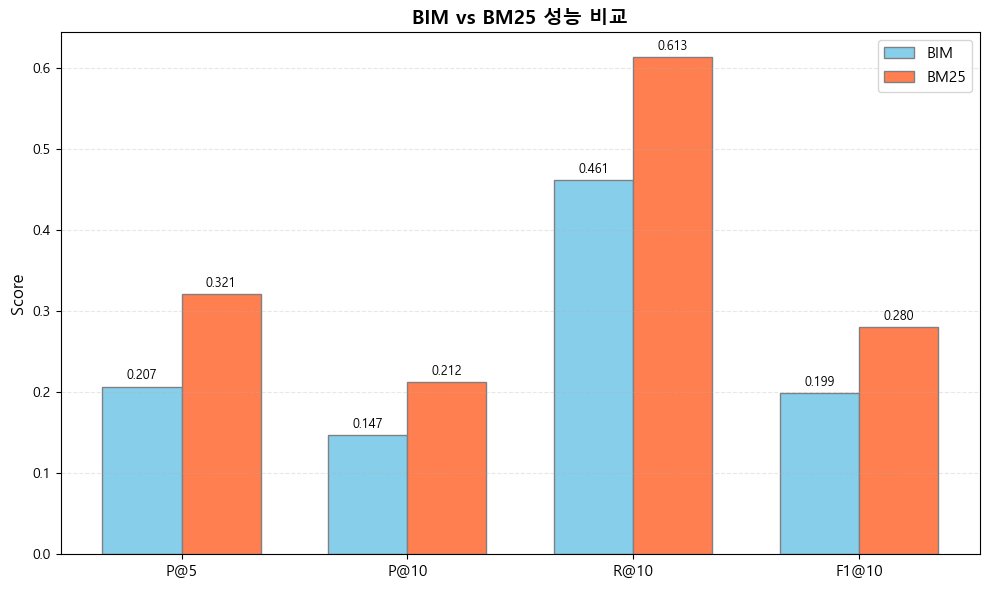

In [5]:
# 그래프 시각화
metrics_to_plot = ['P@5', 'P@10', 'R@10', 'F1@10']
x = np.arange(len(metrics_to_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, [final_metrics['BIM'][m] for m in metrics_to_plot], width, label='BIM', color='skyblue', edgecolor='grey')
rects2 = ax.bar(x + width/2, [final_metrics['BM25'][m] for m in metrics_to_plot], width, label='BM25', color='coral', edgecolor='grey')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('BIM vs BM25 성능 비교', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'performance_comparison_light.png', dpi=300)
plt.show()